In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.backend import concatenate
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from imagePreprocess import getImagesVarAndMean

data/resized/000034.jpg


In [2]:
# TODO:
# find how to use multithreading in jupyter on windows
# unet
# standardize images
dataDir = 'data/resized/'

In [3]:
def showHsv(img):    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

In [4]:
img_in = cv2.imread('pic.jpg')
# maybe should switch to LAB colorspace?
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
print(hsv.shape)

h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 255).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv = cv2.merge([h,s,v])
# print('image with its value untouched, but saturation and hue randomized:');showHsv(hsv)

(1008, 1600, 3)


In [5]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


In [32]:
def loadImgHsv(path):
    img_in = cv2.imread(path)
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218
# in /resized/ they are cropped to be 128x128

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, dim, var, mean, batch_size=32, in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.hsstd = np.sqrt(var[...,:2])
        self.hsmean = mean[...,:2]
        self.vstd = np.sqrt(var[...,2])
        self.vmean = mean[...,2]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImgHsv(dataDir + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        #X = (X - self.vmean)/self.vstd
        X = np.expand_dims(X, axis=len(X.shape))
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [33]:
params = {'dim': (128, 128),
          'batch_size': 32,
          'in_channels': 1,
          'out_channels': 2,
          'shuffle': True}
data_IDs = os.listdir(dataDir)
print('dataset size',len(data_IDs))
trainSplitPercent = 0.1
trainSize = int(len(data_IDs)*trainSplitPercent)
print('trainSize', trainSize)
train_IDs = data_IDs[:trainSize]
print('train len', len(train_IDs))
valSplitPercent = 0.02
valSize = int(len(data_IDs)*valSplitPercent)
splitValAt = int(trainSize + valSize)
val_IDs = data_IDs[trainSize:splitValAt]
print('val len', len(val_IDs))

params['var'], params['mean'] = getImagesVarAndMean([dataDir + x for x in train_IDs], params['dim'] + (3,))


training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape )

#todo change to load hsv

dataset size 202599
trainSize 20259
train len 20259
val len 4051
hash 8114316728054832587
(32, 128, 128, 2)


In [54]:
def createModel(input_shape):
    input_shape = input_shape + (1,)
    inputs = Input(input_shape)
    mul = 2
    conv1 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(128*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv5 = Conv2D(128*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    
    up6 = Conv2D(64*mul, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv3, up6], axis=3)
    conv6 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    up7 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv2, up7], axis=3)
    conv7 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    
    up8 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv1, up8], axis=3)
    conv8 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    # todo change to sigmoid
    conv8 = Conv2D(2, 1, activation = 'relu')(conv8)
    
    model = Model(inputs=inputs, outputs=conv8)
    
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mae','mse'])
    return model

model = createModel(params['dim'])
model.summary()
print(model.output_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 128, 128, 32) 320         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 128, 128, 32) 9248        conv2d_123[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_124[0][0]                 
__________________________________________________________________________________________________
conv2d_125

In [35]:
x = model.layers[0]
x.input

<tf.Tensor 'input_5:0' shape=(?, 128, 128, 1) dtype=float32>

In [55]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['unet2xconv_biggertrain']
NAME = f"test-tensorboard-{ currTime }-layers-" + "_".join(str(l) for l in layers)
print(NAME)

model = createModel(params['dim'])
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
#mode.fit(X, y, batch_size=32, epochs=10, validation_split=0.2, callbacks=[tensorboard])

test-tensorboard-09-05-2019-00-22-08-layers-unet2xconv_biggertrain
Epoch 1/1
633/633 [==============================] - 184s 290ms/step - loss: 4969.3862 - mean_absolute_error: 51.2664 - mean_squared_error: 4969.3862 - val_loss: 3123.3349 - val_mean_absolute_error: 43.5587 - val_mean_squared_error: 3123.3349


In [ ]:
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=3,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])

Epoch 1/3
633/633 [==============================] - 183s 289ms/step - loss: 3077.6294 - mean_absolute_error: 42.7683 - mean_squared_error: 3077.6294 - val_loss: 3140.2098 - val_mean_absolute_error: 41.4363 - val_mean_squared_error: 3140.2098
Epoch 2/3
633/633 [==============================] - 182s 288ms/step - loss: 2958.5736 - mean_absolute_error: 41.8538 - mean_squared_error: 2958.5736 - val_loss: 2963.8520 - val_mean_absolute_error: 42.3149 - val_mean_squared_error: 2963.8520
Epoch 3/3
632/633 [============================>.] - ETA: 0s - loss: 2902.7477 - mean_absolute_error: 41.3683 - mean_squared_error: 2902.7477

In [46]:
def showImgFromPredict(hs, v, showDetails=False):
    '''hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    hs, v = hs[0], v[0,...,0]
#     print('hs:',hs.shape)
    h, s = hs[...,0], hs[...,1]
    print('h',h.shape,'s',s.shape,'v',v.shape)
    print(h.dtype, s.dtype, v.dtype)
    hsv = cv2.merge([h,s,v])
    # showHsv(hsv)    
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    if not showDetails:
        plt.imshow(img)
        plt.show()
        return
    
    f, axarr = plt.subplots(1,4, figsize=(15,15))
    
    axarr[0].imshow(img)
    for i in range(2,-1,-1):
        pic = hsv[:,:,i]
        #axarr.title(['hue', 'saturation', 'value'][i])
        axarr[1+i].title.set_text(['hue', 'saturation', 'value'][i])
        axarr[1+i].imshow(pic, cmap='gray')
    plt.show()

In [47]:
def predictFromImage(img, showDetails=False):
    X, Y = validation_generator[1]
    print('xshape',X.shape, 'yshape',Y.shape)

    inX, inY = loadImgHsv(img )
    #print(inX.shape,inY.shape)
    inX, inY = inX[None,...,None], inY[None,:]
    #print(inX.shape,inY.shape)
    X, Y = X[10][None,:], Y[0][None,:]
    #print(X.shape, Y.shape)

    X, Y = inX, inY
    # 1st layer is hue, 2nd saturation
    predY = model.predict(X)

    #print(X.dtype, X.min(), X.max(), X.mean())
    #predY = int(predY)
    print('predyshape',predY.shape)
    print(predY.min(), predY.max(), predY.mean() )
    print(predY.min(), predY.max(), predY.mean() )
    predY = predY
    predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    #print(predY.min(), predY.max(), predY.mean() )
    #predY[:,0] += 0
    #predY[0,0] = 0
    hue = predY[:,0]
    print('hue',hue.min(), hue.max(), hue.mean() )

    showImgFromPredict(predY, X, showDetails)

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 201.12946 69.95655
0.0 201.12946 69.95655
hue 15 117 54.8984375
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


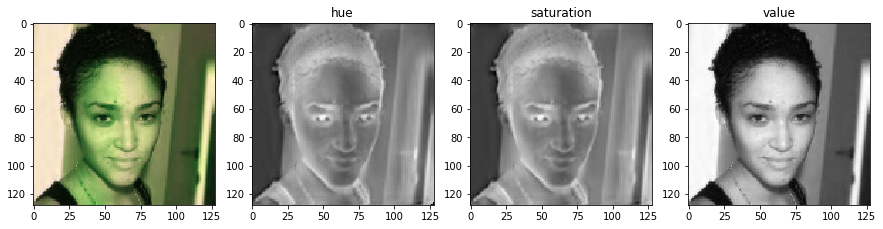

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 186.278 62.63691
0.0 186.278 62.63691
hue 17 144 74.2265625
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


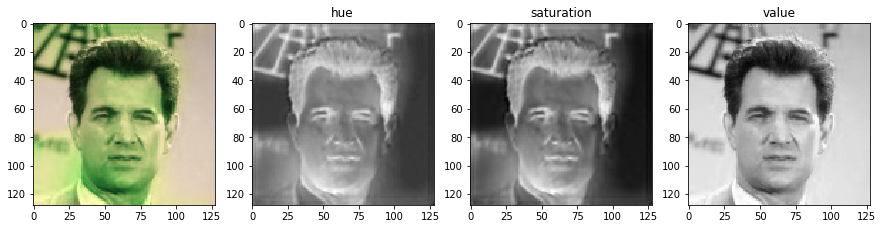

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 185.33186 64.89235
0.0 185.33186 64.89235
hue 20 125 68.421875
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


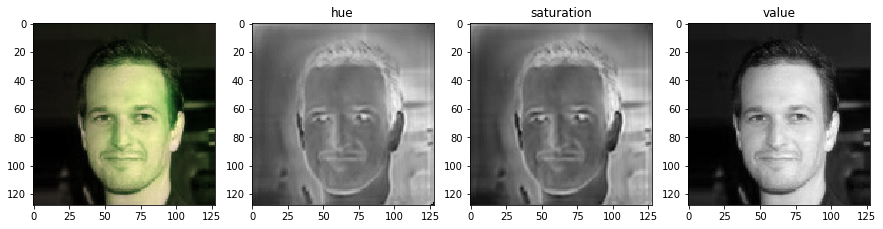

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 226.24147 55.1329
0.0 226.24147 55.1329
hue 14 76 39.01171875
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


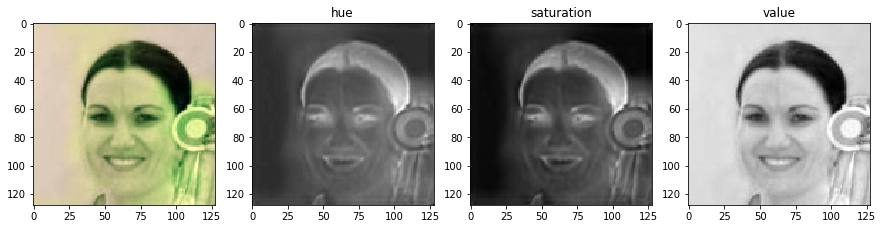

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 184.66112 54.11891
0.0 184.66112 54.11891
hue 16 79 39.76953125
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


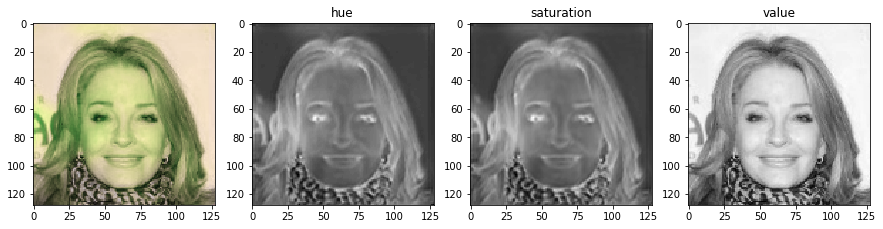

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 203.68011 73.45291
0.0 203.68011 73.45291
hue 30 171 86.7109375
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


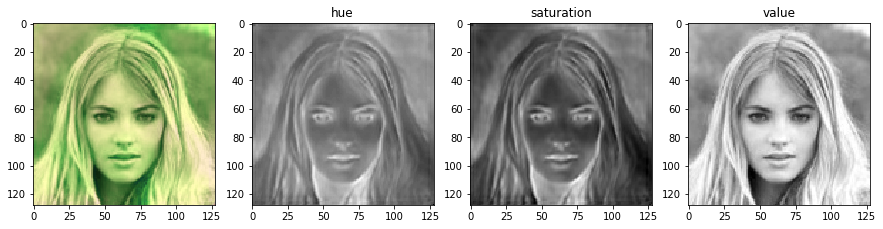

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 212.00926 76.96783
0.0 212.00926 76.96783
hue 14 160 78.37109375
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


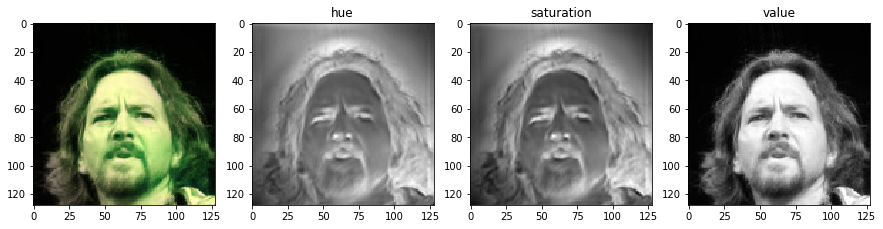

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 181.05692 62.907448
0.0 181.05692 62.907448
hue 18 60 36.0859375
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


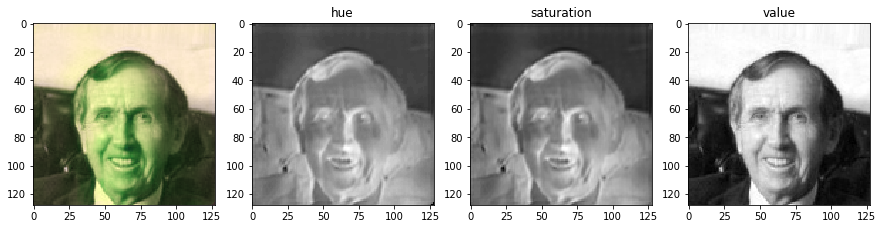

xshape (32, 128, 128, 1) yshape (32, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 169.38571 59.663914
0.0 169.38571 59.663914
hue 12 103 48.140625
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


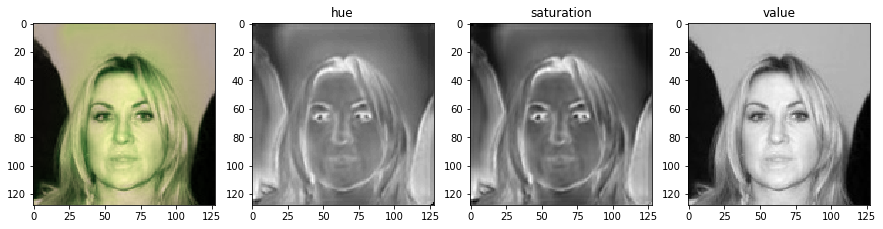

In [56]:
for i in range(1,10):
    predictFromImage(f'data/resized/{i+13:06}.jpg', True)
